# Bolidozor vs optical trajectories - correlation example

**Pred prvnim spustenim vytvorte funkce, které jsou na konci tohoto notebooku

také musí být na počítači nainstalováni MLABvoClient '''sudo pip3 install MLABvo'''


# Events

jednotlivé události meteorů. Obsahují ID z bolidozoru a reálnou trajektorii...

In [5]:
if False:#2057410
    multibolid_id = 2057410
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([44980.37638663])

    met_stop_lat = np.array([48.340593635025])
    met_stop_lon = np.array([6.572188010297])

    met_start_lat = np.array([49.52717828089])
    met_start_lon = np.array([6.763558272451])
    
    met_velocity = [45500]
    model_offset = -8.25

In [6]:
if True:#2047621
    multibolid_id = 2047621
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([41896.884619396])

    met_start_lat = np.array([49.997439391249])
    met_start_lon = np.array([9.692504979925])

    met_stop_lat = np.array([50.035327181108])
    met_stop_lon = np.array([7.560013628387])

    met_velocity = [24500]
    model_offset = 1.44

In [7]:
if True:#2017388
    multibolid_id = 2017388
    met_start_altitude = np.array([55000.0])
    met_stop_altitude = np.array([8910.7633450924])

    met_stop_lon = np.array([6.512636353428])
    met_stop_lat = np.array([51.944553218498])
    
    met_start_lon = np.array([9.996094184309])
    met_start_lat = np.array([51.230870109095])

    met_velocity = [30500]
    model_offset = 7.94

In [8]:
geoC = Geocentric(6378137, 6356752.314)
stations = {}
stations['SVAKOV-R12']={'name': 'SVAKOV','latitude':49.2607,'longitude':14.6917,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['ZVPP-R6']={'name': 'ZVPP','latitude':48.9869,'longitude':14.4675,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['HFN-R1']={'name': 'JHRADEC','latitude':49.1314,'longitude': 14.9999,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['VALMEZ-R1']={'name': 'VALMEZ','latitude':49.463038,'longitude': 17.973544,'elevation':400, 'status': 'testing', 'type': 'receiver'}
stations['DDMTREBIC-R3']={'name': 'TREBIC','latitude':49.2071,'longitude':15.8759,'elevation':480, 'status': 'operational', 'type': 'receiver'}

c = scipy.constants.c
trans_station_point = np.array(geoC.GeographicToGeocentric(47.347993, 5.515079, 190))
t = 0.005
t = 1/96000
t = 1/96000*1000

timesteps = np.arange(-20,5,t)

In [9]:
bz = MLABvo.Bolidozor.Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)

{'api_url': 'http://api.vo.astro.cz/bolidozor/', 'api_version': '0.0.2', 'datetime_start': '2017-12-04 23:46:33.104737', 'job_result_url': 'http://api.vo.astro.cz/bolidozor/job/09a98be3-882b-4f65-882a-fded8b593503', 'job_state': 'PENDING', 'job_id': '09a98be3-882b-4f65-882a-fded8b593503'}



 0 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_raws.fits
delka zaznamu          : 17.6 s
cas prvni. vzorku s GPS: 6.144463541666667 s
cas 1. GPS a konec     : 11.455536458333334 s
SysCas ukladani souboru: 2017-11-11 18:02:09 s
SysCas zacatku souboru : 2017-11-11 18:01:51.400000
SysCas 1. GPS znacky   : 2017-11-11 18:01:57.544464
Korekce systemoveho cas: 0:00:02.455536
Korekce casu zvukovky  : 47.39746403694153
CorCas ukladani souboru: 2017-11-11 18:02:11.455536 s
CorCas zacatku souboru : 2017-11-11 18:01:53.855536
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Pocet vzorku s gps znac: 3863


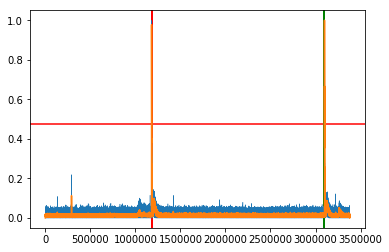


 1 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/11/11/18/20171111180205537_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/11/11/18/20171111180205537_DDMTREBIC-R3_raws.fits
delka zaznamu          : 13.4 s
cas prvni. vzorku s GPS: 5.914083333333333 s
cas 1. GPS a konec     : 7.485916666666667 s
SysCas ukladani souboru: 2017-11-11 18:02:06 s
SysCas zacatku souboru : 2017-11-11 18:01:52.600000
SysCas 1. GPS znacky   : 2017-11-11 18:01:58.514083
Korekce systemoveho cas: 0:00:01.485917
Korekce casu zvukovky  : 11.451082944869995
CorCas ukladani souboru: 2017-11-11 18:02:07.485917 s
CorCas zacatku souboru : 2017-11-11 18:01:54.085917
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Pocet vzorku s gps znac: 1237


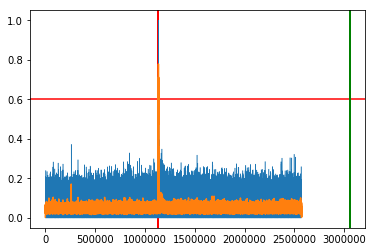


 2 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/11/11/18/20171111180154354_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/11/11/18/20171111180154354_HFN-R1_raws.fits
delka zaznamu          : 18.399989583333333 s
cas prvni. vzorku s GPS: 5.810583333333334 s
cas 1. GPS a konec     : 12.58940625 s
SysCas ukladani souboru: 2017-11-11 18:02:11 s
SysCas zacatku souboru : 2017-11-11 18:01:52.600010
SysCas 1. GPS znacky   : 2017-11-11 18:01:58.410594
Korekce systemoveho cas: 0:00:01.589406
Korekce casu zvukovky  : 0.16458415985107422
CorCas ukladani souboru: 2017-11-11 18:02:12.589406 s
CorCas zacatku souboru : 2017-11-11 18:01:54.189416
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Pocet vzorku s gps znac: 3740


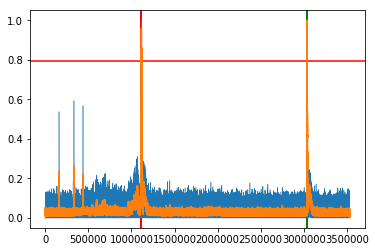

In [10]:
%matplotlib inline
for i, bolid in enumerate(bolids.result):
    try:
        print("\n", i,"==================================\n", "snapshot:", bolid['url_file_js9'])
        bolids.result[i]['time_calib']=MLABvo.Bolidozor.timeCalibration(bolid['url_file_raw'], bolid['station_name'])
    except Exception as e:
        print("ERROR, bolids.result:", e)

In [11]:
selected = list(range(0, len(bolids.result)))
time_offset={}

Using matplotlib backend: TkAgg
0 2017-11-11 18:01:53.855536 SVAKOV-R12
1 2017-11-11 18:01:54.085917 DDMTREBIC-R3
2 2017-11-11 18:01:54.189416 HFN-R1
1510423313.855536 1510423332.589406


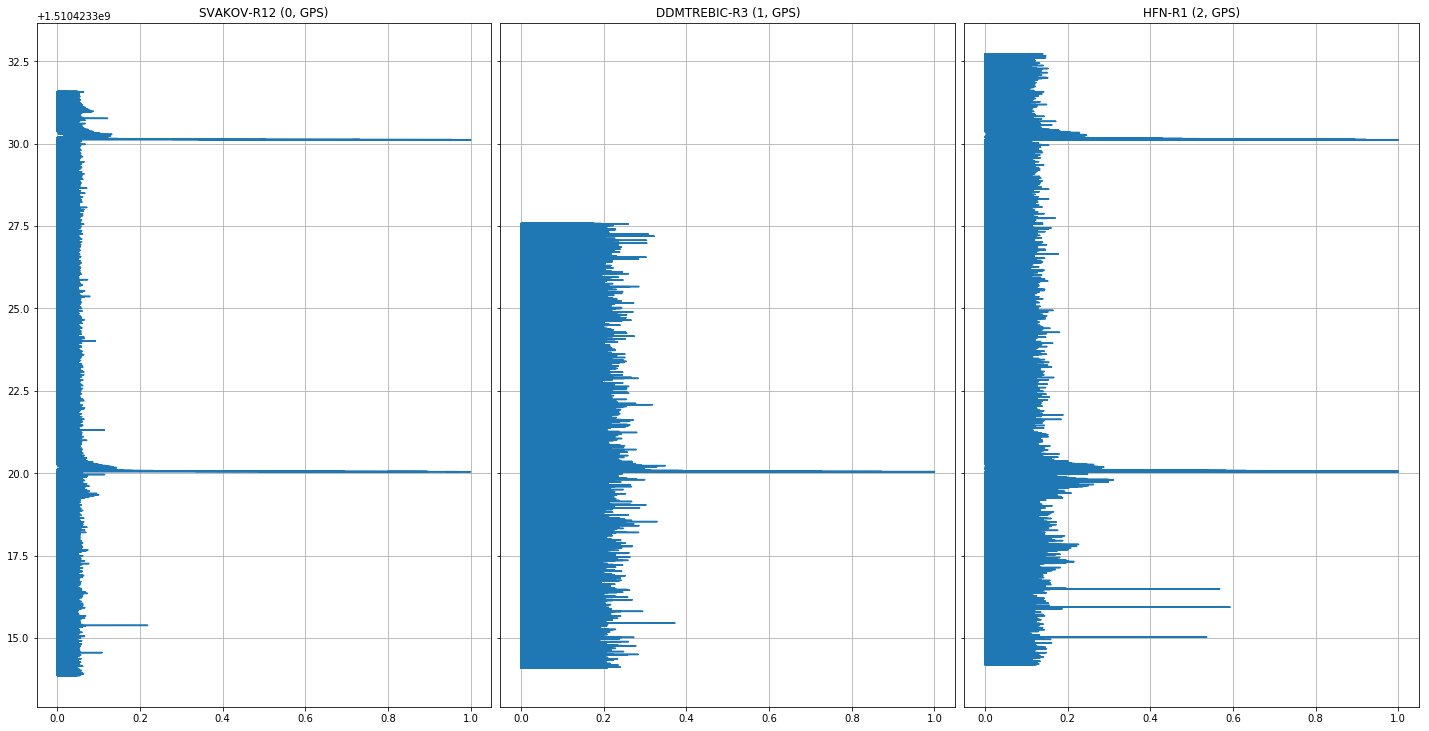

In [12]:
%matplotlib 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    try:
        bolid = bolids.result[selected[i]]
        print (i, bolid['time_calib']['cor_file_beg'], bolid['namesimple'])
        hdulist = fits.open(bolid['url_file_raw'])
        met_data = np.abs(np.ravel(hdulist[0].data))

        T_offset = 10*time_offset.get(selected[i], 0)

        if gps_calib:
            ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
            min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        else:
            ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
            min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        array = np.arange(min_date, max_date, 1/96000/2)
        array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))

        if not minimal_time: minimal_time = min_date
        if not maximal_time: maximal_time = max_date
        if min_date < minimal_time: minimal_time = min_date
        if max_date > maximal_time: maximal_time = max_date

        ax.plot(met_data, array)
        ax.grid(True)
    except Exception as e:
        print(e)

fig.subplots_adjust(wspace=0.02, left = 0.02, right=0.98,bottom=0.02, top=0.97)
print(minimal_time, maximal_time)
plt.show()

In [13]:
%matplotlib tk

meteor = 0

bolid = bolids.result[selected[meteor]]
flat_data = np.ravel(hdulist[0].data)
raw = flat_data[0::2] + 1j * flat_data[1::2]

if gps_calib:
    #ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
    min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
else:
    #ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
    min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))


timesteps = np.arange(-10,5,1/96000)
met_points = np.empty([timesteps.size, 3])
met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
met_vect = met_stop_point - met_start_point
print(met_vect)
for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
    met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[0]))
print("generation of points DONE")
rec_station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))


[ -55348.98914171 -253169.38847937   13468.96909561]
generation of points DONE


In [20]:
print('met_points', met_points)
print('timpstaps', timesteps)
print('rec_station_point', rec_station_point)
print('trans_station_point', trans_station_point)

doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, rec_station_point)

dopp_time = np.vectorize(lambda x: dates.date2num(d1+datetime.timedelta(seconds=(x)+model_offset)))
dopp_freq = np.vectorize(lambda x: ((x)+26500.0))

print(raw)
print(doppler)



met_points [[ 4040256.33872669   998216.70946133  4976719.58606328]
 [ 4040256.27096209   998216.39950227  4976719.60255354]
 [ 4040256.2031975    998216.08954322  4976719.6190438 ]
 ..., 
 [ 3942675.528913     551876.59863105  5000465.51046201]
 [ 3942675.46114841   551876.28867199  5000465.52695227]
 [ 3942675.39338381   551875.97871294  5000465.54344253]]
timpstaps [-10.          -9.99998958  -9.99997917 ...,   4.99996875   4.99997917
   4.99998958]
rec_station_point [ 4034406.01706163  1057781.97186084  4809833.11880581]
trans_station_point [ 4309400.73400393   416092.77960595  4668203.49623901]
[ 0.00054264+0.05730415j -0.00820911+0.04518819j  0.01501334+0.02793241j
 ...,  0.01493442-0.0279758j   0.01917637-0.0486492j
  0.00352788-0.07334042j]
[[ -1.00000000e+01   4.93969135e+03]
 [ -9.99998958e+00   4.93967626e+03]
 [ -9.99997917e+00   4.93966125e+03]
 ..., 
 [  4.99996875e+00  -7.36486391e+03]
 [  4.99997917e+00  -7.36486919e+03]
 [  4.99998958e+00  -7.36486919e+03]]


In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
sample_offset = int(96000*(-2.5))
#sample_offset = int(96000*(-2.45))  #asi optimalni
#sample_offset = int(96000*(-2))
sample_offset = int(96000*(-1))
#sample_offset = int(96000*(0))


x = np.arange(len(f))
y = 1*np.sin(2 * np.pi * doppler[1:,1] * x / 96000)

doppler_signal = np.zeros_like(raw)
np.put(doppler_signal, np.arange(1, len(y))+sample_offset, y, mode='crop')

print(doppler_signal)
print(raw)
print("dopplerTime")
print(doppler[1:,0])

l1 = range(len(raw.real))
l2 = range(len(doppler[1:,0][96000*2:]))

ax1.plot(l1, doppler_signal.real, l1, cor.imag)
ax1.plot(l1, raw.real, l1, raw.imag)
ax1.set_xlim(0,len(raw.real))

arr = waterfall(raw, None, bins = 4096*2)
ax2.imshow(arr.T,  interpolation='none', aspect='auto',  extent=[0, len(raw.real),48000, -48000], cmap=plt.get_cmap('hot'))
ax2.grid(True)
ax2.set_ylim(13000*2,13500*2)
ax2.plot(np.arange(1, len(doppler[:,1]))+sample_offset, doppler[1:,1]+26500.0)

#ax3.plot(scipy.signal.correlate(doppler_signal, raw.real, 'same').real)
ax3.plot(scipy.signal.correlate(raw, doppler_signal, 'same').real)
#ax3.plot(scipy.signal.convolve(raw.real, doppler_signal, 'same').real)
ax3.set_ylim(-300,300)
fig.subplots_adjust(wspace=0.04, hspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)



[ 0.93685395+0.j  0.87701577+0.j  0.79873288+0.j ...,  0.00000000+0.j
  0.00000000+0.j  0.00000000+0.j]
[ 0.00054264+0.05730415j -0.00820911+0.04518819j  0.01501334+0.02793241j
 ...,  0.01493442-0.0279758j   0.01917637-0.0486492j
  0.00352788-0.07334042j]
dopplerTime
[-9.99998958 -9.99997917 -9.99996875 ...,  4.99996875  4.99997917
  4.99998958]


K inicializaci před prvnim spustenim:

In [57]:
import MLABvo.Bolidozor
import MLABvo.BolidozorTools
import numpy as np
import scipy, scipy.constants
import scipy, scipy.signal
from Geocentric import Geocentric
import matplotlib.pyplot as plt
from astropy.io import fits
import datetime
from matplotlib import dates
import recviewer

In [16]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    #wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

In [17]:
def estimate_dopplers2(trajectory, timesteps, f0, trans_station, rec_station):
    # alternative algorithm
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
   
    doppler = np.empty([trajectory.shape[0], 2])
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        try: 
            # angle transmitter - meteor - reciever
            ba = trans_station-trajectory[i]
            bc = rec_station-trajectory[i]
            TMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))

            # angle trajectory - meteor - reciever
            ba = trajectory[i+1]-trajectory[i]
            bc = rec_station-trajectory[i]
            VMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))
            # angle trajectory - meteor - axis (of angle transmitter-meter-reciever)
            VMA = VMR-TMR/2
            #print(np.degrees(VMA))

            # radial speed of meteor to axis of TMR angle (Transmitter - meteor - reciever)
            radial_speed = np.cos(VMA)*(np.linalg.norm(trajectory[i]-trajectory[i+1])/t)
            doppler_offset = (radial_speed/c)*f0
            
        except Exception as e:
            #print(e)
            pass
        
        doppler[i] = np.array([timesteps[i], doppler_offset])
    return doppler